In [158]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

from sklearn.preprocessing import normalize as norm

(-2000.0, -1400.0)

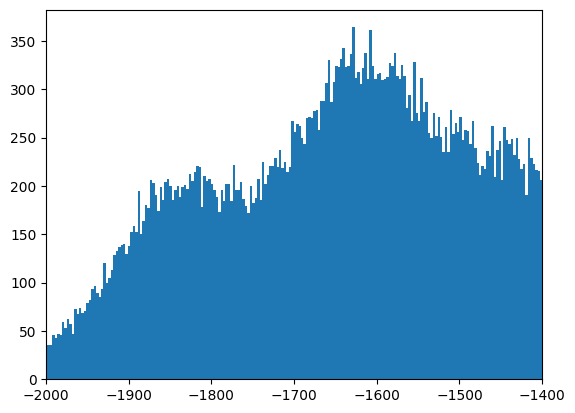

In [159]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values

edge_N, bin_N = load_histo("../Dati/Run_Co_3000_50_ChargeHistos_5_27_2024.dat")

channel = 12


    
edge_N = edge_N[channel]
bin_N = bin_N[channel]




centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)
plt.bar(centers_N, bin_N[:-1], width=centers_N[1]-centers_N[0])
plt.xlim(-2000, -1400)



In [160]:
FILE_PATH = "../Dati/Run_Co_468_Data_5_27_2024_Ascii_0000.root" #Relative file path

file = uproot.open(FILE_PATH)
file["tree"].show()

baselines = np.array(file["tree"]["base"].array()[1:-1]) 
charges = np.array(file["tree"]["charge"].array()[1:-1])
amp = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge = np.array(file["tree"]["letime"].array()[1:-1])
t_edge = np.array(file["tree"]["tetime"].array()[1:-1])
channel= np.array(file["tree"]["ch"].array()[1:-1])
waveform = np.array(file["tree"]["pshape"].array()[1:-1])
flag    = np.array(file["tree"]["Flag"].array()[1:-1]) 

FILE_PATH = "../Dati/Run_Co_468_Data_5_30_2024_Ascii_0000.root"
file2 = uproot.open(FILE_PATH)
file2["tree"].show()

baselines = np.concatenate( (baselines, file2["tree"]["base"].array()[1:-1]) , axis=0 ) 
charges = np.concatenate( (charges, file2["tree"]["charge"].array()[1:-1]), axis=0 )
amp = np.concatenate( (amp, file2["tree"]["amp"].array()[1:-1] ), axis=0 )
lead_edge = np.concatenate( (lead_edge, file2["tree"]["letime"].array()[1:-1]), axis=0 )
t_edge = np.concatenate( (t_edge, file2["tree"]["tetime"].array()[1:-1]), axis=0 )
channel= np.concatenate( (channel, file2["tree"]["ch"].array()[1:]), axis=0 )
waveform = np.concatenate( (waveform, file2["tree"]["pshape"].array()[1:-1] ), axis=0 )
flag = np.concatenate( (flag, file2["tree"]["Flag"].array()[1:-1] ), axis=0 )


FILE_PATH = "../Dati/Run_Co_correlations_Data_5_23_2024_Ascii_0000.root" #Relative file pathù
file = uproot.open(FILE_PATH)
file["tree"].show()

baselines_2500 = np.array(file["tree"]["base"].array()[1:-1]) 
charges_2500 = np.array(file["tree"]["charge"].array()[1:-1])
amp_2500 = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge_2500 = np.array(file["tree"]["letime"].array()[1:-1])
t_edge_2500 = np.array(file["tree"]["tetime"].array()[1:-1])
channel_2500= np.array(file["tree"]["ch"].array()[1:-1])
waveform_2500 = np.array(file["tree"]["pshape"].array()[1:-1])
flag_2500    = np.array(file["tree"]["Flag"].array()[1:-1])


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
Flag                 | int32_t[2]               | AsDtype("('>i4', (2,))")
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...
name                 | typename                 | interpretation                
---------------------

# sampling 468 ps

In [132]:
print(np.shape(flag))

[7050, 2]


In [161]:
N_ch= len(charges[0])
N_ev=len(charges)
print(N_ev, N_ch)

7050 16


[451, 2] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] [51. 70. 61. 35. 32. 63. 28. 52. 38. 21.]


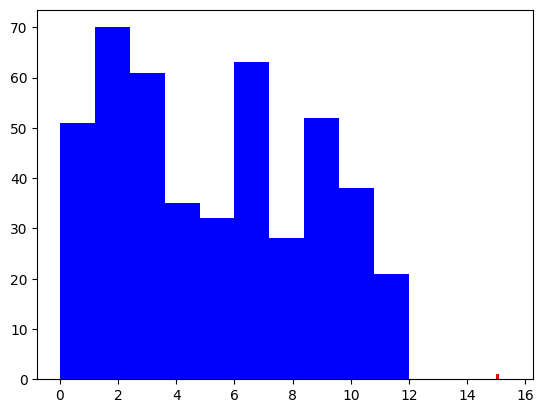

In [134]:
#posso controllare come un canale è accoppiato agli altri
ch=14
msk=np.where(flag[:,0]== ch)[0]
bin_1, _, _=plt.hist(flag[msk, 1],color = "red")
msk=np.where(flag[:,1]== ch)[0]
bin_2,_, _=plt.hist(flag[msk, 0],color="blue")

print(np.shape(flag[msk, :]), bin_1, bin_2)

#

ad ogni event è associata una flag, ora devo selezionare tutti gli event con una stessa flag

In [135]:
def timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh):
    wf_1_len = len(paired_wf_1)
    new_wf_1 = np.array(paired_wf_1).reshape([np.array(paired_wf_1).shape[0], 1, np.array(paired_wf_1).shape[1]])

    for evt in range(new_wf_1.shape[0]):
        for ch in range(new_wf_1.shape[1]):
            bsl_1 = new_wf_1[evt, ch, 0:32].mean()
            new_wf_1[evt, ch, :] = np.convolve(new_wf_1[evt, ch], [1/n_mean] * n_mean, mode = "same") - bsl_1

    new_wf_1 = -norm(-new_wf_1.reshape(-1, 1024), norm = "max", axis = 1, copy = True, return_norm = False)
    threshold = thresh

    ledges1 = np.zeros(new_wf_1.shape[0])

    for evt in range(new_wf_1.shape[0]):
        try:
            ledge= np.where(np.diff(np.sign(new_wf_1[evt] - threshold)))[0][0]
            coef = np.polyfit(new_wf_1[evt][ledge-shiftL:ledge+shiftR],np.arange(ledge-shiftL, ledge+shiftR),1)
            ledges1[evt] = np.poly1d(coef)(threshold) 
        except IndexError:
            continue

    return ledges1*sampling

In [136]:
#data una coppia e un dataset la funzione ritorna l'offset relativo alla misura di timing
def offset_and_resolution_estimation( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)


In [137]:
def offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    offset_matrix=np.zeros((N_ch, N_ch))
    sigma_offset=np.zeros((N_ch, N_ch))
    time_res=[]
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
            offset_matrix[i][j]=tmp[0]
            sigma_offset[i][j]=tmp[1]
            time_res.append(tmp[3])
    return(offset_matrix, sigma_offset, time_res)

In [138]:
def resolution_estimation_corrected( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)-offset_matrix[couple[0], couple[1]]
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), np.std(timeres[msk])/len(msk), timeres.tolist())
    else:
        return(0,0,0,0)

In [139]:
def flatten(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return flattened

In [162]:
sampling=0.468
shiftR=2
shiftL=0
n_mean=30
thresh=-0.1
a=offset_and_resolution_estimation([1,1], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
print(a[3])


0


[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


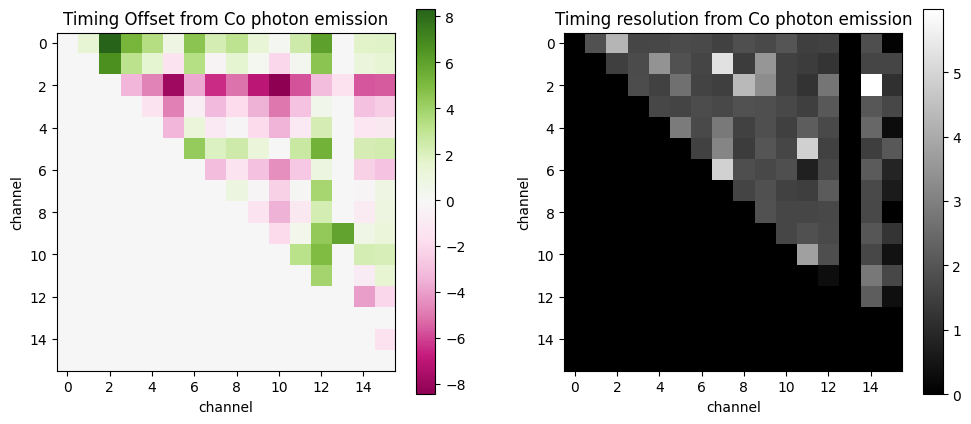

In [163]:
N_ch=16
a=offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
offset_matrix=a[0]
sigma_matrix=a[1]
time_res=a[2]
print(offset_matrix[0])



plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(offset_matrix, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

plt.subplot(1,2,2)
plt.imshow(sigma_matrix, cmap='gray')
plt.title("Timing resolution from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")
plt.show()


time_res = np.array(flatten(time_res))
msk=np.where(time_res != 0)
#_, _, _=plt.hist(time_res[msk], bins=100, range=(-15,15))


<class 'list'>
4.1894513555759465 1.6940829927787613


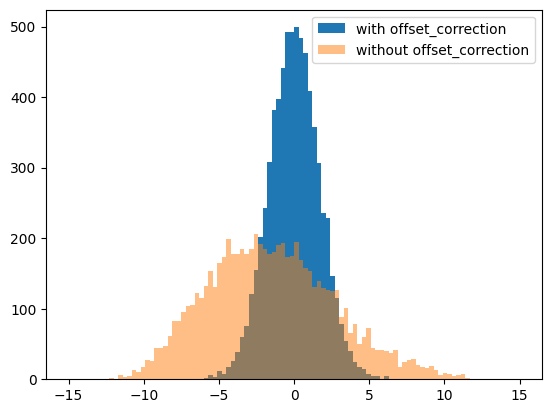

In [166]:
time_res_new=[]
print(type(time_res_new))
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix)
        time_res_new.append(tmp[3])

time_res_new = np.array(flatten(time_res_new))
msk_new=np.where(time_res_new != 0)
_, _, _=plt.hist(time_res_new[msk_new], bins=100, range=(-15,15), label='with offset_correction')
_, _, _=plt.hist(time_res[msk], bins=100, range=(-15,15), alpha=0.5, label='without offset_correction')
plt.legend()


print(np.std(time_res[ (time_res != 0) & (np.abs(time_res) < 15) ]), np.std(time_res_new[(time_res_new != 0) & (np.abs(time_res_new) < 15)]))

In [143]:
print(offset_matrix[0])

[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


# sampling 2500 ps

In [167]:
N_ch= len(charges_2500[0])
N_ev=len(charges_2500)
print(N_ev, N_ch)

7452 16


(936, 2) [ 0.  0.  0.  0.  0. 47.  0.  0.  0.  0.] [124. 102.  77.  60.  64. 130.  65.  92.  91. 131.]


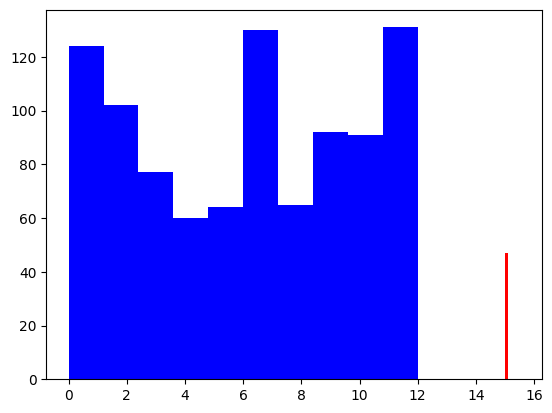

In [168]:
ch=14
msk=np.where(flag_2500[:,0]== ch)[0]
bin_1, _, _=plt.hist(flag_2500[msk, 1],color = "red")
msk=np.where(flag_2500[:,1]== ch)[0]
bin_2,_, _=plt.hist(flag_2500[msk, 0],color="blue")

print(np.shape(flag_2500[msk, :]), bin_1, bin_2)

In [169]:
print(offset_matrix[0])

[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]


Text(0, 0.5, 'channel')

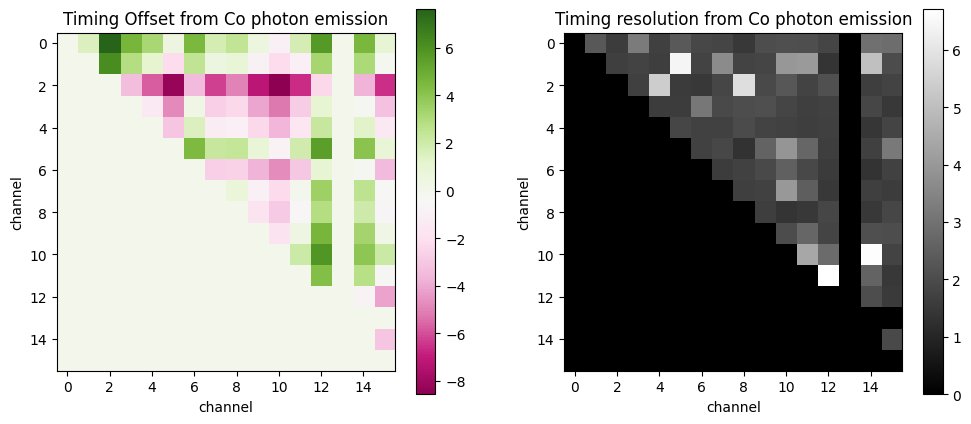

In [170]:
sampling=2.5
shiftR=2
shiftL=0
n_mean=8
thresh=-0.1

N_ch=16
print(offset_matrix[0])
a=offset_matrix_filling(N_ch, flag_2500, waveform_2500, sampling, shiftR, shiftL, n_mean, thresh)
offset_matrix_2500=a[0]
sigma_matrix_2500=a[1]
time_res_2500=a[2]
time_res_2500 = np.array(flatten(time_res_2500))
msk=np.where(time_res_2500 != 0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(offset_matrix_2500, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

plt.subplot(1,2,2)
plt.imshow(sigma_matrix_2500, cmap='gray')
plt.title("Timing resolution from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

<class 'list'>
4.040662535946477 1.6940829927787613


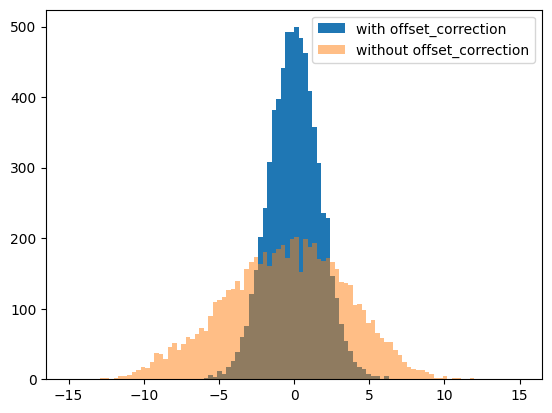

In [172]:
time_res_2500_new=[]
print(type(time_res_2500_new))
N_ch=16
for i in range(N_ch):
    for j in range(N_ch):
        tmp=resolution_estimation_corrected([i,j], flag_2500, waveform_2500, sampling, shiftR, shiftL, n_mean, thresh, offset_matrix_2500)
        time_res_2500_new.append(tmp[3])

time_res_2500_new = np.array(flatten(time_res_new))
msk_new=np.where(time_res_2500_new != 0)
_, _, _=plt.hist(time_res_2500_new[msk_new], bins=100, range=(-15,15), label='with offset_correction')
_, _, _=plt.hist(time_res_2500[msk], bins=100, range=(-15,15), alpha=0.5, label='without offset_correction')
plt.legend()

print(np.std(time_res_2500[ (time_res_2500 != 0) & (np.abs(time_res_2500) < 15) ]), np.std(time_res_2500_new[(time_res_2500_new != 0) & (np.abs(time_res_2500_new) < 15)]))

[0.         1.38187253 8.31786349 5.17512394 3.35986042 0.74819754
 4.53816511 2.2289446  3.04694161 1.32099059 0.17669283 2.44340537
 6.05595569 0.         1.76219085 1.81066295]
[ 0.          1.50500943  7.62525845  4.61293362  3.15892701  0.42782056
  4.49672154  1.77843779  2.40697245  0.59281318 -0.90675317  1.68751028
  5.71198922  0.          4.56768762  0.97792598]


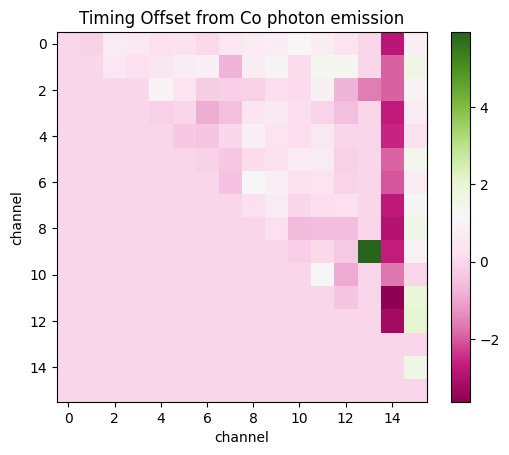

In [149]:
#calcolo la differenza tra gli offset a 2500 e quelli a 468
plt.imshow(offset_matrix-offset_matrix_2500, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

print(offset_matrix[0])
print(offset_matrix_2500[0])

# sommo 

In [150]:
print(np.abs(sigma_matrix/offset_matrix))

[[        nan  1.40126483  0.51052536  0.3185908   0.49425989  2.36479201
   0.37849469  0.69728547  0.60969258  1.29248733 11.31478332  0.60313571
   0.2509946          nan  1.04585239  0.0442332 ]
 [        nan         nan  0.22257378  0.57290033  2.20527177  1.33919099
   0.48833584 19.53004043  0.94012719 17.39720492  0.74785082  4.62414156
   0.27277858         nan  1.47147391  1.16790034]
 [        nan         nan         nan  0.53396173  0.32556096  0.3343681
   0.42190456  0.23129351  0.8467876   0.47040808  0.18004249  0.20897637
   0.87756517  0.          1.05907926  0.2032672 ]
 [        nan         nan         nan         nan  1.10961815  0.33459323
   2.63481436  0.52515991  1.01599578  0.53298532  0.33146096  0.51893305
   4.04790365         nan  0.69891652  0.66304203]
 [        nan         nan         nan         nan         nan  0.85677088
   1.48185805  2.57055521  7.69434582  0.96976606  0.43643499  2.03801169
   0.78583079         nan  1.85721356  0.25410452]
 [    

/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_77998/3486559899.py:1: RuntimeWarning: invalid value encountered in divide
  print(np.abs(sigma_matrix/offset_matrix))


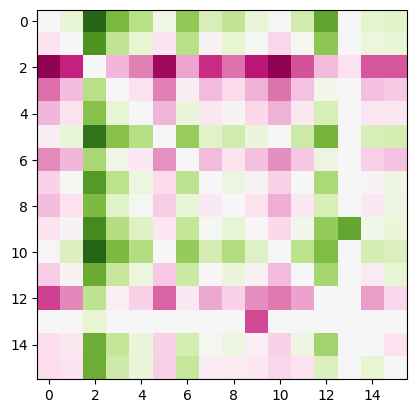

In [151]:
for i in range(N_ch):
    for j in range(i):
        offset_matrix[i][j]=-offset_matrix[j][i]

plt.imshow(offset_matrix, cmap='PiYG')

In [152]:
def save_matrix(filename, offset_matrix):
    np.savez(filename, offset_matrix)

def load_matrix(filename):
    return(np.load(filename))

save_matrix('offset_matrix.npz', offset_matrix)
loaded=load_matrix('offset_matrix.npz')
print(loaded.files)
matrix_loaded = loaded['arr_0']
print(matrix_loaded)


['arr_0']
[[ 0.          1.38187253  8.31786349  5.17512394  3.35986042  0.74819754
   4.53816511  2.2289446   3.04694161  1.32099059  0.17669283  2.44340537
   6.05595569  0.          1.76219085  1.81066295]
 [-1.38187253  0.          6.63130884  3.08321902  1.56085596 -1.42436184
   3.31263649 -0.27002431  1.5401779   0.20180509 -2.0706521   0.30490605
   4.57495114  0.          1.10332797  1.3971629 ]
 [-8.31786349 -6.63130884  0.         -3.34271168 -4.75683674 -7.88589878
  -3.76222109 -6.43956906 -5.10787089 -7.02622831 -8.44476913 -5.71107384
  -3.12476136 -1.57517162 -5.64903925 -5.62315052]
 [-5.17512394 -3.08321902  3.34271168  0.         -1.49626089 -4.8014284
  -0.68136343 -3.21157612 -1.89431539 -3.49485563 -5.08918001 -2.84121581
   0.50915704  0.         -2.93159673 -2.52846673]
 [-3.35986042 -1.56085596  4.75683674  1.49626089  0.         -3.38142368
   1.17680446 -1.10830173 -0.20296721 -1.91677204 -3.46563689 -1.07002225
   2.20121727  0.         -1.29611636 -1.176552